In [1]:
import sys
import obspy
import os,glob
import time
import numpy as np
import pandas as pd
from seisgo.utils import split_datetimestr
from seisgo import downloaders,noise,utils

## 1. Download example data.

In [2]:
# paths and filenames
rootpath = "data_test" # roothpath for the project
DATADIR  = os.path.join(rootpath,'Raw')                   # where to store the downloaded data
down_list  = os.path.join(DATADIR,'station.txt')
# CSV file for station location info

# download parameters
source='IRIS'                                 # client/data center. see https://docs.obspy.org/packages/obspy.clients.fdsn.html for a list
max_tries = 10                                                  #maximum number of tries when downloading, in case the server returns errors.
flag      = True                                               # print progress when running the script; recommend to use it at the begining
samp_freq = 20                                                  # targeted sampling rate at X samples per seconds
rmresp   = True
rmresp_out = 'DISP'
pressure_chan = [None]  #Added by Xiaotao Yang. This is needed when downloading some special channels, e.g., pressure data. VEL output for these channels.
freqmin   = 0.01                                                # pre filtering frequency bandwidth
freqmax   = 10
# note this cannot exceed Nquist freq

# targeted region/station information: only needed when use_down_list is False
lamin,lamax,lomin,lomax= 39,40,-89,-88                # regional box: min lat, min lon, max lat, max lon (-114.0)
chan_list = ["HHZ"]
net_list  = ["GS"] #                                             # network list
sta_list  = ["DEC05","DEC07"]                                               # station (using a station list is way either compared to specifying stations one by one)
start_date = "2014_02_01_0_0_0"                               # start date of download
end_date   = "2014_02_01_12_0_0"                               # end date of download
inc_hours  = 6                                                 # length of data for each request (in hour)
maxseischan = 1                                                  # the maximum number of seismic channels, excluding pressure channels for OBS stations.
ncomp      = maxseischan #len(chan_list)

##################################################
# we expect no parameters need to be changed below
# assemble parameters used for pre-processing waveforms in downloading
prepro_para = {'rmresp':rmresp,'rmresp_out':rmresp_out,'freqmin':freqmin,'freqmax':freqmax,\
                'samp_freq':samp_freq}

downlist_kwargs = {"source":source, 'net_list':net_list, "sta_list":sta_list, "chan_list":chan_list, \
                    "starttime":start_date, "endtime":end_date, "maxseischan":maxseischan, "lamin":lamin, "lamax":lamax, \
                    "lomin":lomin, "lomax":lomax, "pressure_chan":pressure_chan, "fname":down_list}

In [3]:
tt0=time.time()

if not os.path.isdir(DATADIR):os.makedirs(DATADIR)
stalist=downloaders.get_sta_list(**downlist_kwargs) # saves station list to "down_list" file
                                          # here, file name is "station.txt"
# save parameters for future reference
metadata = os.path.join(DATADIR,'download_info.txt')
fout = open(metadata,'w')
fout.write(str({**prepro_para,**downlist_kwargs,'inc_hours':inc_hours,'ncomp':ncomp}));fout.close()

all_chunk = split_datetimestr(start_date,end_date,inc_hours)
if len(all_chunk)<1:
    raise ValueError('Abort! no data chunk between %s and %s' % (start_date,end_date))

########################################################
#################DOWNLOAD SECTION#######################
########################################################
# loop through each time chunk
for ick in range(len(all_chunk)-1):
    s1= all_chunk[ick]
    s2=all_chunk[ick+1]
    
    print('time segment:'+s1+' to '+s2)
    
    download_kwargs = {"source":source,"rawdatadir": DATADIR, "starttime": s1, "endtime": s2, \
              "stationinfo": down_list,**prepro_para}

    # Download for ick
    downloaders.download(**download_kwargs)

tt1=time.time()
print('downloading step takes %6.2f s' %(tt1-tt0))

station.list selected [False] for data from 2014_02_01_0_0_0 to 2014_02_01_12_0_0 with 6h interval
GS.DEC05.HHZ
GS.DEC07.HHZ
time segment:2014_02_01_00_00_00 to 2014_02_01_06_00_00
GS.DEC05.HHZ  downloading ... try 1
station GS.DEC05 --> seismic channel: HHZ
  downsamping from 200 to 20
  removing response using inv for GS.DEC05.HHZ
  downloaded GS.DEC05.HHZ in 27.288002729415894 seconds.
 Saving data for GS.DEC05.HHZ
GS.DEC07.HHZ  downloading ... try 1
station GS.DEC07 --> seismic channel: HHZ
  downsamping from 200 to 20
  removing response using inv for GS.DEC07.HHZ
  downloaded GS.DEC07.HHZ in 47.803333044052124 seconds.
 Saving data for GS.DEC07.HHZ
time segment:2014_02_01_06_00_00 to 2014_02_01_12_00_00
GS.DEC05.HHZ  downloading ... try 1
station GS.DEC05 --> seismic channel: HHZ
  downsamping from 200 to 20
  removing response using inv for GS.DEC05.HHZ
  downloaded GS.DEC05.HHZ in 28.095642805099487 seconds.
 Saving data for GS.DEC05.HHZ
GS.DEC07.HHZ  downloading ... try 1
stat

## 2. Cross-correlations


In [4]:
# absolute path parameters
CCFDIR    = os.path.join(rootpath,'CCF')                                    # dir to store CC data

# some control parameters
freq_norm   = 'phase_only'                                                  # 'no' for no whitening, or 'rma' for running-mean average, 'phase' for sign-bit normalization in freq domain
time_norm   = 'no'                                                          # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'                                                       # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma" and time_norm to "no"
flag        = True                                                         # print intermediate variables and computing time for debugging purpose
acorr_only  = False                                                         # only perform auto-correlation
xcorr_only  = True                                                          # only perform cross-correlation or not
ncomp       = 1                                                             # 1 or 3 component data (needed to decide whether do rotation)
exclude_chan = []        #Added by Xiaotao Yang. Channels in this list will be skipped.

# pre-processing parameters
cc_len    = 7200                                                            # basic unit of data length for fft (sec)
step      = 3600                                                             # overlapping between each cc_len (sec)
smooth_N  = 20                                                              # moving window length for time/freq domain normalization if selected (points)

# cross-correlation parameters
maxlag         = 50                                                        # lags of cross-correlation to save (sec)
substack       = False                                                      # sub-stack daily cross-correlation or not
substack_len   = 2*cc_len                                                  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
smoothspect_N  = 20                                                         # moving window length to smooth spectrum amplitude (points)

# criteria for data selection
max_over_std = 10                                                           # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# make a dictionary to store all variables: also for later cc
fc_para={'inc_hours':inc_hours,'cc_len':cc_len,'step':step,'ncomp':ncomp,\
         'freqmin':freqmin,'freqmax':freqmax,'freq_norm':freq_norm,'time_norm':time_norm,\
         'cc_method':cc_method,'smooth_N':smooth_N,'substack':substack,'substack_len':substack_len,\
         'smoothspect_N':smoothspect_N,'maxlag':maxlag,'max_over_std':max_over_std}
# save fft metadata for future reference
fc_metadata  = os.path.join(CCFDIR,'fft_cc_data.txt')

if not os.path.isdir(CCFDIR):os.makedirs(CCFDIR)

# save metadata
fout = open(fc_metadata,'w')
fout.write(str(fc_para));fout.close()

# set variables to broadcast
tdir = sorted(glob.glob(os.path.join(DATADIR,'*.h5')))

In [5]:
#loop through all data files.
for ick in range(len(tdir)):
    sfile=tdir[ick]
    t10=time.time()
    #call the correlation wrapper.
    noise.do_correlation(sfile,ncomp,inc_hours,cc_len,step,maxlag,cc_method=cc_method,
                         acorr_only=acorr_only,xcorr_only=xcorr_only,substack=substack,
                         smoothspect_N=smoothspect_N,substack_len=substack_len,
                         maxstd=max_over_std,freqmin=freqmin,freqmax=freqmax,
                         time_norm=time_norm,freq_norm=freq_norm,smooth_N=smooth_N,
                         exclude_chan=exclude_chan,outdir=CCFDIR)

    t11 = time.time()
    print('it takes %6.2fs to process the chunk of %s' % (t11-t10,sfile.split('/')[-1]))

found 2 station-components in total
working on file: 2014-02-01T00-00-00.000000ZT2014-02-01T06-00-00.000000Z.h5
FFT for station DEC05 and trace hhz_01
Initializing FFTData with whitening ...
FFT for station DEC07 and trace hhz_01
Initializing FFTData with whitening ...
2014-02-01T00-00-00.000000ZT2014-02-01T06-00-00.000000Z.h5
receiver: GS DEC07
CorrData saved to: data_test/CCF/2014-02-01T00-00-00.000000ZT2014-02-01T06-00-00.000000Z.h5
it takes   0.20s to process the chunk of 2014-02-01T00-00-00.000000ZT2014-02-01T06-00-00.000000Z.h5
found 2 station-components in total
working on file: 2014-02-01T06-00-00.000000ZT2014-02-01T12-00-00.000000Z.h5
FFT for station DEC05 and trace hhz_01
Initializing FFTData with whitening ...
FFT for station DEC07 and trace hhz_01
Initializing FFTData with whitening ...
2014-02-01T06-00-00.000000ZT2014-02-01T12-00-00.000000Z.h5
receiver: GS DEC07
CorrData saved to: data_test/CCF/2014-02-01T06-00-00.000000ZT2014-02-01T12-00-00.000000Z.h5
it takes   0.20s to 

## 3. Check cross-correlation results

In [6]:
ccfiles = sorted(glob.glob(os.path.join(CCFDIR,'*.h5')))

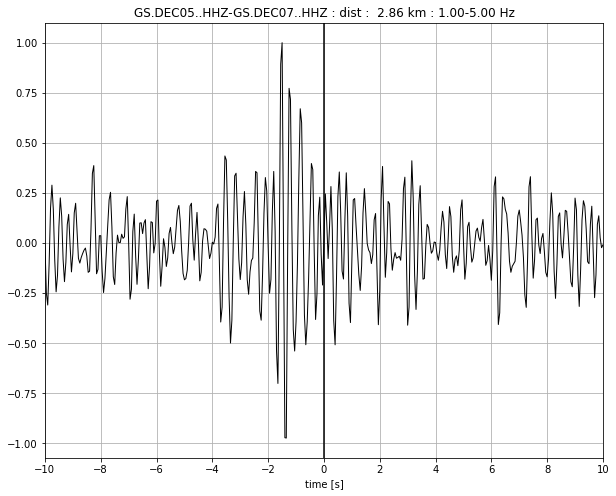

In [9]:
corrdata=noise.extract_corrdata(ccfiles[0])
clist=list(corrdata.keys())
cc_comp='ZZ'
corrdata[clist[0]][cc_comp].plot(freqmin=1,freqmax=5,lag=10)